# RL CW 3

In [12]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [13]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


#Import needed modules

In [14]:
#from gym.wrappers.monitoring.video_recorder import VideoRecorder
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import torch
from torch import nn
from collections import namedtuple, deque
from copy import deepcopy, copy
from scipy.ndimage.filters import uniform_filter1d

#Set up Q network

In [15]:
device = 'cpu'

class QNetwork(nn.Module):

  def __init__(self, env, learning_rate=1e-3, epsilon=1, n_nodes=16):
    super(QNetwork, self).__init__()
    self.input_size = env.observation_space.shape[0]
    self.output_size = env.action_space.n
    self.actions = np.arange(self.output_size)
    self.learning_rate = learning_rate
    self.epsilon=epsilon
    
    # Initialise the neural network architecture
    self.model = nn.Sequential(
        nn.Linear(self.input_size, n_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(n_nodes, n_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(n_nodes, n_nodes, bias=True),
        nn.ReLU(),
        nn.Linear(n_nodes, self.output_size, bias=True)).to(device)

    # Initialise the optimiser
    self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def forward(self, state):
    return self.model(state)

  def get_action(self, state):
    # Random action
    if np.random.random() < self.epsilon: 
      action = env.action_space.sample()
    else: # Greedy action
      t_state = torch.FloatTensor(state).to(device)
      q_values = self.forward(t_state)
      action = torch.max(q_values, axis=0)[1].item()
    return action

# Create a DQN agent

In [16]:
class DQNAgent():

  def __init__(self, Q1, env=gym.make("CartPole-v0"), N_samples=32, memory_size=1e4, burn_in=1e3, gamma=0.99):
    self.env = env
    self.Q1 = Q1
    self.Q2 = deepcopy(Q1)
    self.N_samples = N_samples
    self.memory_size = memory_size
    self.current_state = self.env.reset()

    #Initialise the memory
    self.D = deque(maxlen = int(memory_size))
    self.memory_unit = namedtuple('memory_unit', field_names=['state', 'action', 'reward', 'done', 'next_state'])
    
    self.burn_in = burn_in
    self.gamma = gamma

  def update_memory(self, action, reward, next_state, done):
    self.D.append(self.memory_unit(self.current_state, action, reward, next_state, done))

  def step(self, stage='train'):
    if stage == 'burn_in':
      action = self.env.action_space.sample()
    else:
      # get an action based on the current state (epsilon-greedy way)
      action = self.Q1.get_action(self.current_state)

    # take the step
    next_state, reward, done, info = self.env.step(action)

    # update the memory and current state
    self.update_memory(action, reward, next_state, done)
    self.current_state = next_state.copy()

    # Reset if terminal state
    if done:
      self.current_state = self.env.reset()
    return reward, done

  def get_minibatch_loss(self,):
    # Take sample of random indices from memory
    minibatch_inds = np.random.choice(np.arange(len(self.D)), size=self.N_samples, replace=False)
    # Get the samples from the random indices
    minibatch = zip(*[self.D[i] for i in minibatch_inds])

    # Take the information out of each memory_unit
    states, actions, rewards, next_states, dones = [i for i in minibatch]

    # Convert rewards to float tensor
    t_rewards = torch.FloatTensor(rewards).to(device)
    # Convert actions to integer tensor
    t_actions = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device)
    # Convert dones to bool tensor
    t_dones = torch.BoolTensor(dones).to(device)

    # Convert states to float tensors
    t_states = torch.FloatTensor(np.array([np.ravel(state) for state in states])).to(device)
    t_next_states = torch.FloatTensor(np.array([np.ravel(state) for state in next_states])).to(device)

    # Get Q1(S_j, A_j, theta_0)
    t_q1_hat = torch.gather(self.Q1.forward(t_states), 1, t_actions)

    # Get max(Q2(S_j+1, theta_1))
    t_q2_hat = torch.max(self.Q2.forward(t_next_states), dim=-1)[0].detach()

    # Set Q2 values of terminal states to 0
    t_q2_hat[t_dones] = 0

    # Calculate y
    t_y = self.gamma * t_q2_hat + t_rewards

    # Calculate the loss
    loss = nn.MSELoss()(t_y, t_q1_hat.reshape(-1))
    #loss = nn.SmoothL1Loss()(t_y, t_q1_hat.reshape(-1))
    
    return loss

  def grad_descent(self):

    #Perform a gradient descent step for the minibatch sample
    self.Q1.optimizer.zero_grad()
    loss = self.get_minibatch_loss()
    loss.backward()
    self.Q1.optimizer.step()

    return loss.item()

#Function to run above classes

In [17]:
def run_DQN(epsilon=0.05, learning_rate=1e-3, C=250, n_nodes=16, M=100,\
      env=gym.make("CartPole-v0"), burn_in=1e3, N_samples=32, memory_size=1e4, gamma=0.99, eps_reduction=1/100, threshold = 200):

  # Initialise action-value network q_hat_1 with random weights theta_1
  Q1 = QNetwork(env=env, learning_rate=learning_rate, epsilon=epsilon, n_nodes=n_nodes)

  # Create the agent
  agent = DQNAgent(Q1, env=env, N_samples=N_samples, memory_size=memory_size, burn_in=burn_in, gamma=gamma)

  # Initialise the outputs
  episode_rewards = []
  episode_losses = []
  episode_lengths = []

  #Perform random steps in the burn_in
  step_count = 0
  while burn_in > step_count:
    reward, done = agent.step(stage='burn_in')
    step_count += 1
    if done:
      agent.env.reset()

  step_count = 0
  # Loop through the episodes
  for episode in range(M):

    # Reset environment at the start of each episode
    agent.env.reset()
    
    # Reset episode outputs
    done = False
    total_loss = 0
    total_reward = 0
    episode_length = 0

    # Loop until terminal state
    while done is False:

      # Choose epsilon-greedy action, take step and store in D
      reward, done = agent.step()

      # Perform gradient descent step
      loss = agent.grad_descent()

      # Every C steps update theta_2 = theta_1
      if step_count % C == 0:
        agent.Q2.load_state_dict(agent.Q1.state_dict())

      step_count += 1
      total_loss += loss
      total_reward += reward
      episode_length += 1

    episode_rewards.append(total_reward)
    episode_losses.append(total_loss)
    episode_lengths.append(episode_length)
    
    #Calculate the rolling mean over the past 100 episodes
    mean_rewards = np.mean(episode_rewards[-100:])
    print("\rEpisode = {:d}, Mean Rewards = {:.2f}, Episode Length = {:d}".format(
                        episode, mean_rewards, episode_length), end="")
    
    if mean_rewards > threshold:
      print()
      print('Environment Solved')
      break

    # reduce epsilon
    if agent.Q1.epsilon > 0:
      agent.Q1.epsilon *= eps_reduction
    
  return np.array(episode_rewards), np.array(episode_losses), np.array(episode_lengths), agent

#Run the DQN for CartPole

In [18]:
# Parameters
M = 2000 # number of episodes

# Hyperparameters
burn_in = 1000
learning_rate = 1e-3
C = 20  # frequency of swapping over weights
n_nodes = 16
eps = 1 # exploration rate
N_samples = 32  # batch size
memory_size = 1e3  # buffer size
gamma = 0.99 # discount factor
eps_reduction = 0.99 # amount to reduce epsilon by per episode
threshold = 195

env = gym.make("CartPole-v0")

rewards, losses, lengths, agent = run_DQN(epsilon=eps, learning_rate=learning_rate, C=C, n_nodes=n_nodes, M=M,\
env=env, burn_in=burn_in, N_samples=N_samples, memory_size=memory_size, gamma=gamma, eps_reduction=eps_reduction, threshold=threshold)
mean_DQN_rewards = rewards
mean_DQN_losses = losses

Episode = 364, Mean Rewards = 195.40, Episode Length = 200
Environment Solved


#Plot the graphs

In [19]:
np.savetxt('cartpole.txt',mean_DQN_rewards,fmt="%d")

In [20]:
dummy = np.loadtxt('cartpole.txt',dtype=int)

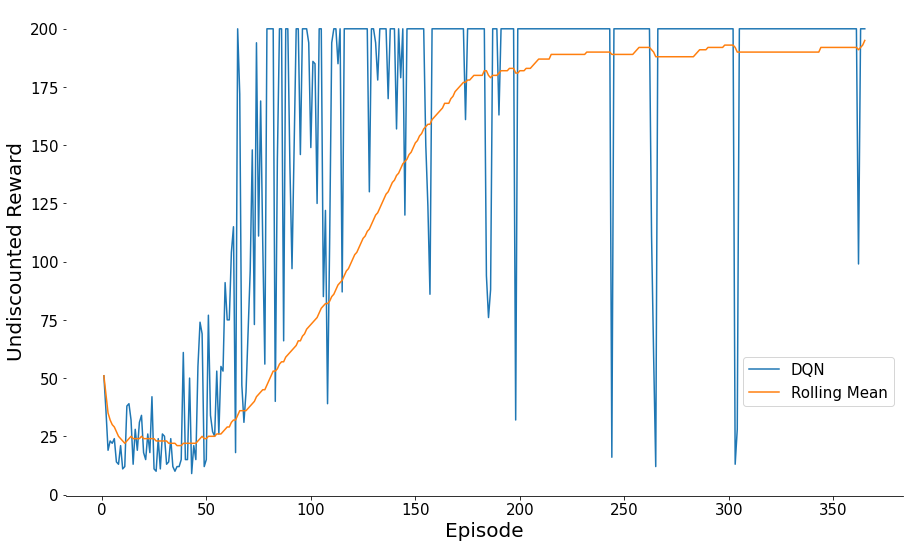

<Figure size 432x288 with 0 Axes>

In [21]:
import seaborn as sns

m = dummy.shape[0]

rolling_mean = uniform_filter1d(dummy, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(dummy[:100])/np.arange(1,101)

fig, ax = plt.subplots(figsize=(15, 9))
sns.despine(left=True, top=True, right=True)

#plt.title('A plot of the DQN agent\'s performance over episode',fontsize=25)
plt.ylabel('Undiscounted Reward',fontsize=20)
plt.xlabel('Episode',fontsize=20)
ax.plot(np.arange(1, m+1), dummy, label='DQN')
ax.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.xticks(size=15)
plt.yticks(size=15)
ax.grid(False)
plt.legend(fontsize=15,bbox_to_anchor=(0.8, 0.3))
plt.show()

plt.savefig("CP.png",bbox_inches='tight')


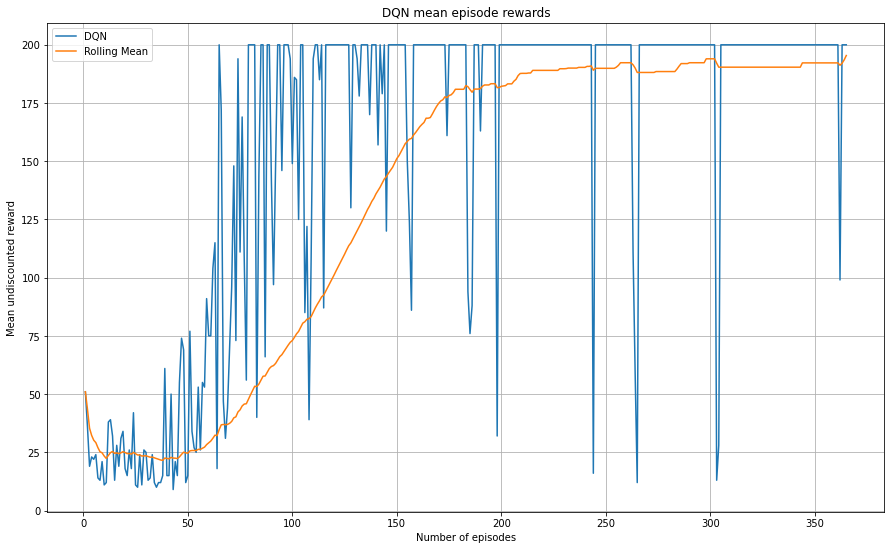

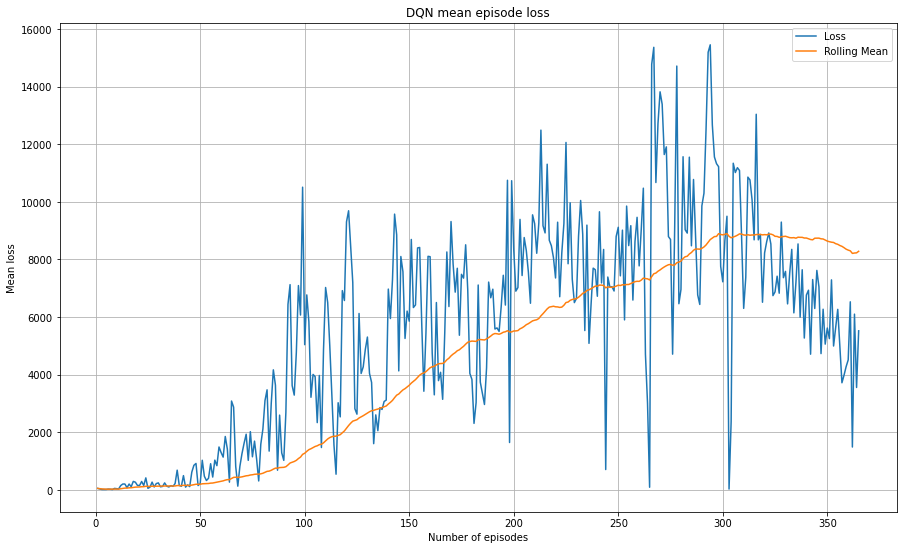

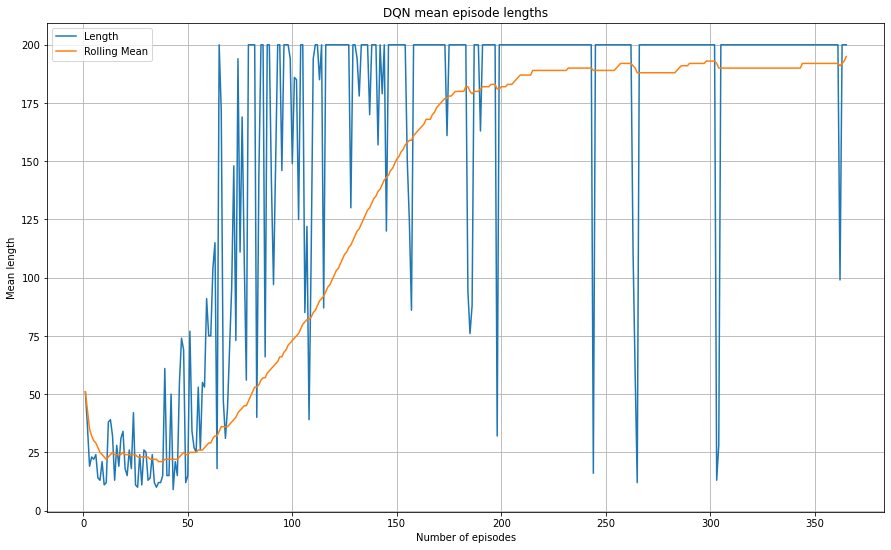

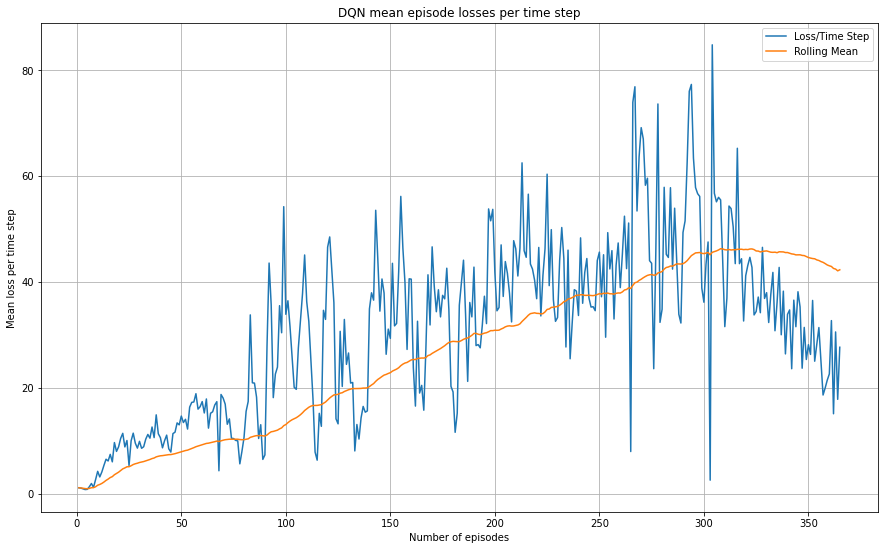

In [23]:
rolling_mean = uniform_filter1d(rewards, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(rewards[:100])/np.arange(1,101)

m = rewards.shape[0]
fig = plt.figure(figsize=(15,9))
plt.title('DQN mean episode rewards')
plt.ylabel('Mean undiscounted reward')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), rewards, label='DQN')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()


rolling_mean = uniform_filter1d(losses, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(losses[:100])/np.arange(1,101)

fig = plt.figure(figsize=(15,9))
plt.title('DQN mean episode loss')
plt.ylabel('Mean loss')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), losses, label='Loss')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()

rolling_mean = uniform_filter1d(lengths, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(lengths[:100])/np.arange(1,101)

fig = plt.figure(figsize=(15,9))
plt.title('DQN mean episode lengths')
plt.ylabel('Mean length')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), lengths, label='Length')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()

rolling_mean = uniform_filter1d(losses/lengths, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(losses[:100]/lengths[:100])/np.arange(1,101)

fig = plt.figure(figsize=(15,9))
plt.title(f'DQN mean episode losses per time step')
plt.ylabel('Mean loss per time step')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), losses/lengths, label='Loss/Time Step')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()

#Run the code for Lunar Lander

In [89]:
class QNetwork(nn.Module):

  def __init__(self, env, learning_rate=1e-3, epsilon=1, n_nodes=16):
    super(QNetwork, self).__init__()
    self.input_size = env.observation_space.shape[0]
    self.output_size = env.action_space.n
    self.actions = np.arange(self.output_size)
    self.learning_rate = learning_rate
    self.epsilon=epsilon

    # Initialise the neural network architecture
    torch.manual_seed(2)
    #torch.manual_seed_all(2)
    self.model = nn.Sequential(
        nn.Linear(self.input_size, 256, bias=True),
        nn.ReLU(),
        nn.Linear(256, 128, bias=True),
        nn.ReLU(),
        nn.Linear(128, self.output_size, bias=True)).to(device)
    # Initialise the optimizer 
    self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def forward(self, state):
    return self.model(state)

  def get_action(self, state):
    # Random action
    if np.random.random() < self.epsilon: 
      action = env.action_space.sample()
    else: # Greedy action
      t_state = torch.FloatTensor(state).to(device)
      q_values = self.forward(t_state)
      action = torch.max(q_values, axis=0)[1].item()
    return action

In [ ]:
class DQNAgent():

  def __init__(self, Q1, env=gym.make("CartPole-v0"), N_samples=32, memory_size=1e4, burn_in=1e3, gamma=0.99):
    self.env = env
    self.Q1 = Q1
    self.Q2 = deepcopy(Q1)
    self.N_samples = N_samples
    self.memory_size = memory_size
    self.current_state = self.env.reset()

    #Initialise the memory
    self.D = deque(maxlen = int(memory_size))
    self.memory_unit = namedtuple('memory_unit', field_names=['state', 'action', 'reward', 'done', 'next_state'])
    
    self.burn_in = burn_in
    self.gamma = gamma

  def update_memory(self, action, reward, next_state, done):
    self.D.append(self.memory_unit(self.current_state, action, reward, next_state, done))

  def step(self, stage='train'):
    if stage == 'burn_in':
      action = self.env.action_space.sample()
    else:
      # get an action based on the current state (epsilon-greedy way)
      action = self.Q1.get_action(self.current_state)

    # take the step
    next_state, reward, done, info = self.env.step(action)

    # update the memory and current state
    self.update_memory(action, reward, next_state, done)
    self.current_state = next_state.copy()

    # Reset if terminal state
    if done:
      self.current_state = self.env.reset()
    return reward, done

  def get_minibatch_loss(self,):
    # Take sample of random indices from memory
    minibatch_inds = np.random.choice(np.arange(len(self.D)), size=self.N_samples, replace=False)
    # Get the samples from the random indices
    minibatch = zip(*[self.D[i] for i in minibatch_inds])

    # Take the information out of each memory_unit
    states, actions, rewards, next_states, dones = [i for i in minibatch]

    # Convert rewards to float tensor
    t_rewards = torch.FloatTensor(rewards).to(device)
    # Convert actions to integer tensor
    t_actions = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device)
    # Convert dones to bool tensor
    t_dones = torch.BoolTensor(dones).to(device)

    # Convert states to float tensors
    t_states = torch.FloatTensor(np.array([np.ravel(state) for state in states])).to(device)
    t_next_states = torch.FloatTensor(np.array([np.ravel(state) for state in next_states])).to(device)

    # Get Q1(S_j, A_j, theta_0)
    t_q1_hat = torch.gather(self.Q1.forward(t_states), 1, t_actions)

    # Get max(Q2(S_j+1, theta_1))
    t_q2_hat = torch.max(self.Q2.forward(t_next_states), dim=-1)[0].detach()

    # Set Q2 values of terminal states to 0
    t_q2_hat[t_dones] = 0

    # Calculate y
    t_y = self.gamma * t_q2_hat + t_rewards

    # Calculate the loss
    loss = nn.MSELoss()(t_y, t_q1_hat.reshape(-1))
    #loss = nn.SmoothL1Loss()(t_y, t_q1_hat.reshape(-1))
    
    return loss

  def grad_descent(self):

    #Perform a gradient descent step for the minibatch sample
    self.Q1.optimizer.zero_grad()
    loss = self.get_minibatch_loss()
    loss.backward()
    self.Q1.optimizer.step()

    return loss.item()

In [90]:
# Parameters
M = 700 # number of episodes

# Hyperparameters
burn_in = 1000
learning_rate = 1e-3
C = 20  # frequency of swapping over weights
n_nodes = 64
eps = 1 # exploration rate
N_samples = 64  # batch size
memory_size = 5e5  # buffer size
gamma = 0.99 # discount factor
eps_reduction = 0.9 # amount to reduce epsilon by per episode
threshold = 200

env = gym.make("LunarLander-v2")

rewards, losses, lengths, agent = run_DQN(epsilon=eps, learning_rate=learning_rate, C=C, n_nodes=n_nodes, M=M,\
env=env, burn_in=burn_in, N_samples=N_samples, memory_size=memory_size, gamma=gamma, eps_reduction=eps_reduction, threshold=threshold)
mean_DQN_rewards = rewards
mean_DQN_losses = losses

Episode = 185, Mean Rewards = 201.79, Episode Length = 440
Environment Solved


In [81]:
rolling_mean = uniform_filter1d(mean_DQN_rewards, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(mean_DQN_rewards[:100])/np.arange(1,101)
np.savetxt('rewards.txt',rolling_mean,fmt="%d")

## Plot the rewards per episode

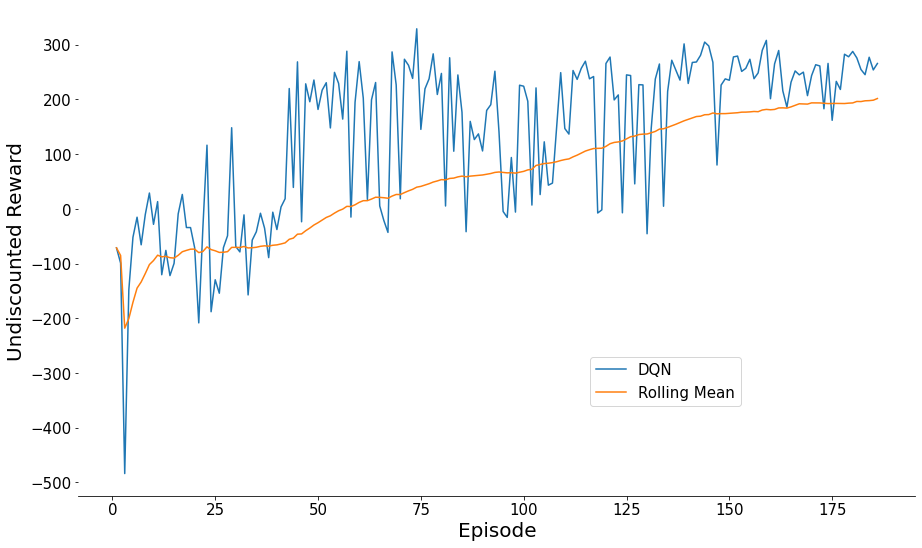

In [91]:
m = mean_DQN_rewards.shape[0]

rolling_mean = uniform_filter1d(mean_DQN_rewards, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(mean_DQN_rewards[:100])/np.arange(1,101)

fig, ax = plt.subplots(figsize=(15, 9))
sns.despine(left=True, top=True, right=True)

#plt.title('A plot of the DQN agent\'s performance over episode',fontsize=25)
plt.ylabel('Undiscounted Reward',fontsize=20)
plt.xlabel('Episode',fontsize=20)
ax.plot(np.arange(1, m+1), mean_DQN_rewards, label='DQN')
ax.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.xticks(size=15)
plt.yticks(size=15)
ax.grid(False)
plt.legend(fontsize=15,bbox_to_anchor=(0.8, 0.3))
plt.show()

## Plot the losses/time_step for each episode

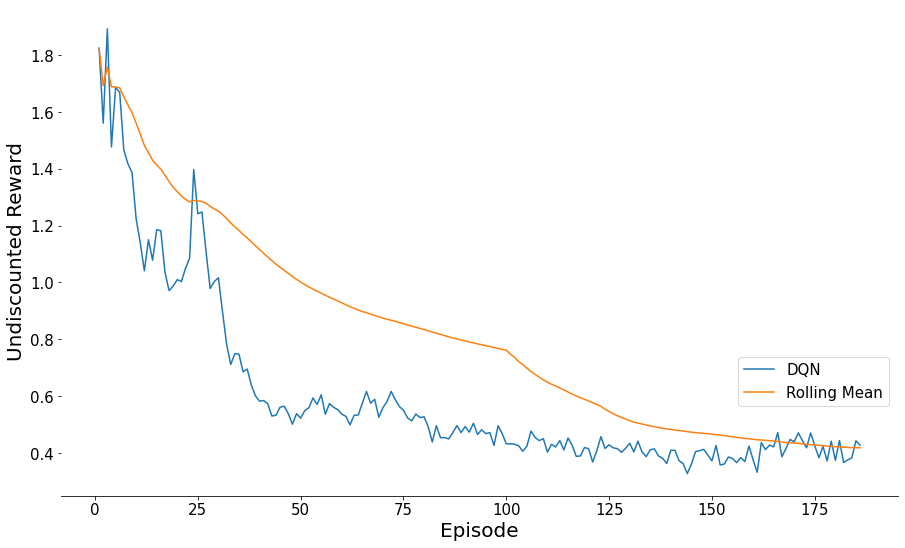

In [94]:
rolling_mean = uniform_filter1d(mean_DQN_losses/lengths, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(mean_DQN_losses[:100]/lengths[:100])/np.arange(1,101)

fig, ax = plt.subplots(figsize=(15, 9))
sns.despine(left=True, top=True, right=True)

#plt.title('A plot of the DQN agent\'s performance over episode',fontsize=25)
plt.ylabel('Undiscounted Reward',fontsize=20)
plt.xlabel('Episode',fontsize=20)
ax.plot(np.arange(1, m+1), mean_DQN_losses/lengths, label='DQN')
ax.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.xticks(size=15)
plt.yticks(size=15)
ax.grid(False)
plt.legend(fontsize=15,bbox_to_anchor=(0.8, 0.3))
plt.show()

## Plot all the graphs

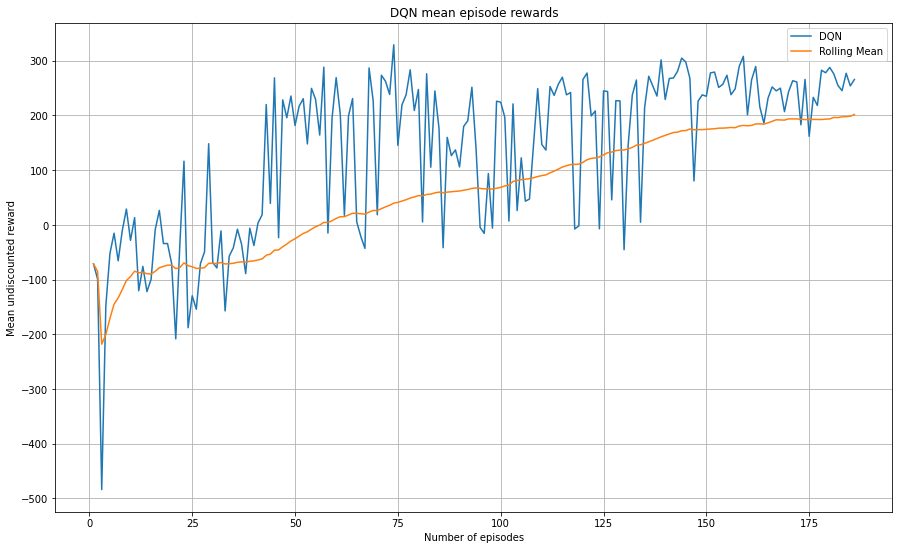

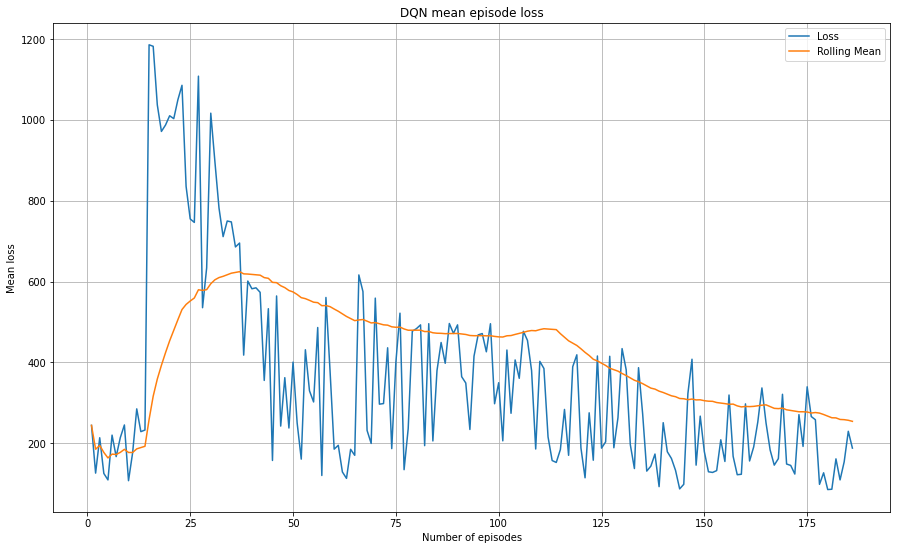

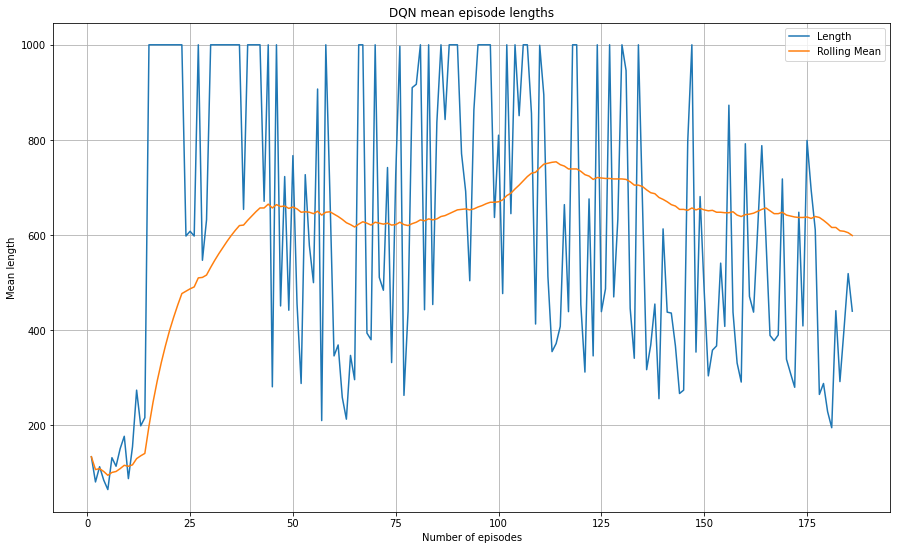

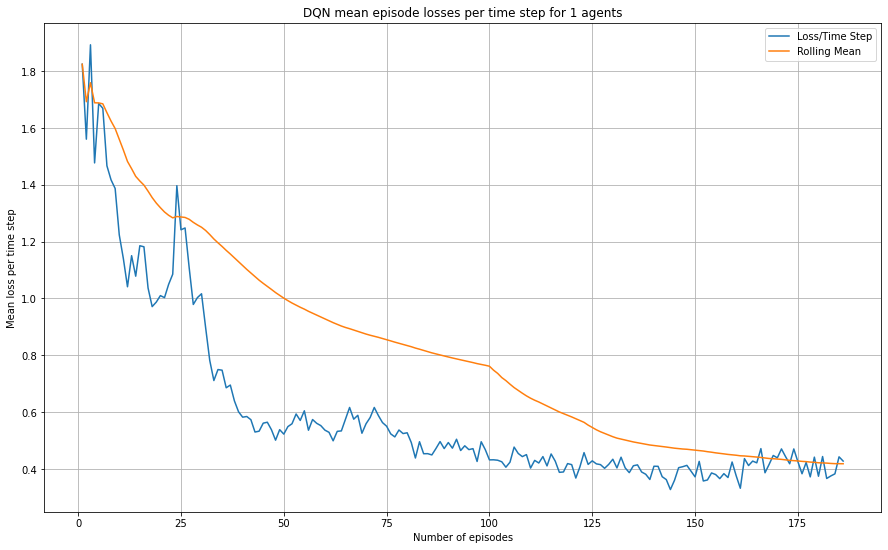

In [92]:
rolling_mean = uniform_filter1d(rewards, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(rewards[:100])/np.arange(1,101)

m = rewards.shape[0]
fig = plt.figure(figsize=(15,9))
plt.title('DQN mean episode rewards')
plt.ylabel('Mean undiscounted reward')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), rewards, label='DQN')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()


rolling_mean = uniform_filter1d(losses, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(losses[:100])/np.arange(1,101)

fig = plt.figure(figsize=(15,9))
plt.title('DQN mean episode loss')
plt.ylabel('Mean loss')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), losses, label='Loss')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()

rolling_mean = uniform_filter1d(lengths, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(lengths[:100])/np.arange(1,101)

fig = plt.figure(figsize=(15,9))
plt.title('DQN mean episode lengths')
plt.ylabel('Mean length')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), lengths, label='Length')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()

rolling_mean = uniform_filter1d(losses/lengths, size=100, mode='nearest', origin=49)
rolling_mean[:100] = np.cumsum(losses[:100]/lengths[:100])/np.arange(1,101)

fig = plt.figure(figsize=(15,9))
plt.title(f'DQN mean episode losses per time step for {n_agents} agents')
plt.ylabel('Mean loss per time step')
plt.xlabel('Number of episodes')
plt.plot(np.arange(1, m+1), losses/lengths, label='Loss/Time Step')
plt.plot(np.arange(1, m+1), rolling_mean, label='Rolling Mean')
plt.grid()
plt.legend()
plt.show()

#Run the display to get the output video

Code often crashes the notebook so it has been commented out.

In [95]:
#display = Display(visible=0, size=(400, 300))
#display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1003'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1003'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
#agent.env.reset()
#agent.Q1.epsilon = 0
#prev_screen = agent.env.render(mode='rgb_array')
#plt.imshow(prev_screen)

#video_recorder = VideoRecorder(agent.env, 'LunarLandingEnd.mp4', enabled=True)

In [ ]:
#done = False
#while not done:
  #agent.env.render(mode='rgb_array')
  #video_recorder.capture_frame() 
  
  #reward, done = agent.step()
  ##next_state, reward, done, info = env.step(env.action_space.sample()) # take a random action
#print('Saved video.')
#video_recorder.close()
#video_recorder.enabled = False
#agent.env.close()